In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Optimization

**Optuna**, en iyi hiperparametreleri bulmak için verimli arama tekniklerini kullanan gelişmiş bir hiperparametre optimizasyon kitaplığıdır. Burada, Optuna kullanarak KNN, MLP ve SVM modellerinin hiperparametre optimizasyonunu göstereceğim.

In [2]:
pip install optuna


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.9 MB/s eta 0:00:00


In [151]:
import optuna
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
import numpy as np


#Load Data

In [94]:
data_path = '/content/drive/My Drive/veri-seti.txt'


In [95]:
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(data_path, header=None, names=column_names, delimiter='\t')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [96]:
print(f"Total number of samples and features: {data.shape}")

Total number of samples and features: (768, 9)


In [97]:
print(data.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [98]:
print(f"Number of samples: {data.shape[0]}")

Number of samples: 768


In [99]:
print(f"Number of features: {data.shape[1]}")

Number of features: 9


#Dataset Info

In [100]:
data_info = data.info()
data_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [101]:
data_description = data.describe()
data_description

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#Preprocessing

In [102]:
data = data.dropna()

In [103]:
for column in data.columns:
    if data[column].dtype == 'object':
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])


In [104]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [105]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [107]:
print(f"Features: X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Labels: y_train: {y_train.shape}, y_test: {y_test.shape}")


Features: X_train: (537, 8), X_test: (231, 8)
Labels: y_train: (537,), y_test: (231,)


#1.Naive Bayes

Naive Bayes algoritması genellikle hiperparametre optimizasyonuna ihtiyaç duymaz çünkü bu algoritma, basit ve varsayımsal bir modeldir. Naive Bayes, her bir özellik için sınıf koşullu bağımsızlık varsayımına dayanır ve bu nedenle modelin ayarlanabilir birçok parametresi yoktur. Bu durum, Naive Bayes'in eğitim ve tahmin işlemlerinin hızlı ve verimli olmasını sağlar.

In [108]:
nb = GaussianNB()
nb.fit(X_train, y_train)


GaussianNB()

In [109]:
y_pred_nb = nb.predict(X_test)

In [43]:
print("Naive Bayes Model")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))
print("Classification Report:")
print(classification_report(y_test, y_pred_nb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb)}")

Naive Bayes Model
Confusion Matrix:
[[119  32]
 [ 27  53]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       151
           1       0.62      0.66      0.64        80

    accuracy                           0.74       231
   macro avg       0.72      0.73      0.72       231
weighted avg       0.75      0.74      0.75       231

Accuracy: 0.7445887445887446


**precision (kesinlik):**
Sınıf 0: **0.82**
Sınıf 1: **0.62**
Kesinlik (precision) Sınıf 0 için Sınıf 1'e göre daha yüksektir, bu da modelin negatif örnekleri daha iyi tahmin ettiğini gösterir.

**recall (duyarlılık):**
Sınıf 0: **0.79**
Sınıf 1: **0.66**
recall (duyarlılık) Sınıf 0 için Sınıf 1'e göre daha iyidir, bu da modelin negatif örnekleri daha iyi tanımladığını gösterir.

**f1-score:**
Sınıf 0: **0.80**
Sınıf 1: **0.64**
Kesinlik ve duyarlılığın bir kombinasyonu olan f1-score, Sınıf 0 için Sınıf 1'e göre daha yüksektir, bu da modelin negatif örnekler üzerinde daha dengeli bir performans gösterdiğini gösterir.

**accuracy (doğruluk): 0.74**
Modelin genel doğruluğu 0.74 (74%) olup, modelin örneklerin **%74**'ünü doğru bir şekilde sınıflandırdığını gösterir.

In [110]:
# Extract metrics from confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
TN_nb, FP_nb, FN_nb, TP_nb = cm_nb.ravel()
sensitivity_nb = TP_nb / (TP_nb + FN_nb)
specificity_nb = TN_nb / (TN_nb + FP_nb)

print(f"Sensitivity (Recall): {sensitivity_nb}")
print(f"Specificity: {specificity_nb}")

Sensitivity (Recall): 0.6625
Specificity: 0.7880794701986755


In [111]:
# ROC Curve
y_pred_prob_nb = nb.predict_proba(X_test)[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_prob_nb)
auc_nb = roc_auc_score(y_test, y_pred_prob_nb)


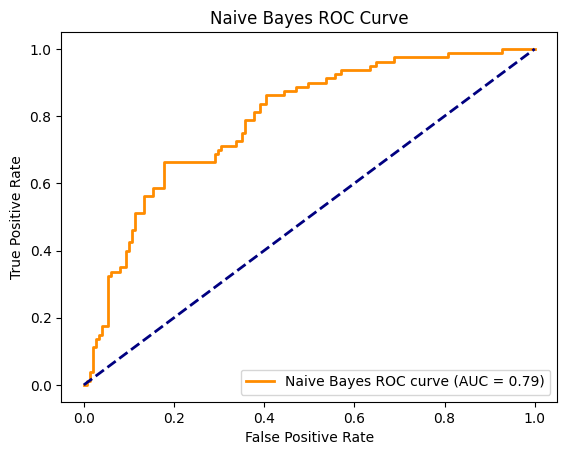

In [112]:
plt.figure()
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label=f'Naive Bayes ROC curve (AUC = {auc_nb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes ROC Curve')
plt.legend(loc="lower right")
plt.show()

Naive Bayes modelinin AUC skoru **0.79**'dur. Bu, modelin sınıflandırma performansının nispeten iyi olduğunu gösterir. Naive Bayes modeli bu veri setinde kabul edilebilir bir performans sergilemiş ve yüksek AUC skoru göstermiştir. Bu model, pozitif örneklerin tanımlanmasında (yüksek recall) iyi performans gösterir.

In [113]:
# Mean Squared Error
mse_nb = mean_squared_error(y_test, y_pred_nb)
print(f"Naive Bayes Mean Squared Error: {mse_nb}")

Naive Bayes Mean Squared Error: 0.2554112554112554


Ortalama Karesel Hatası (Mean Squared Error veya MSE), tahmin modellerindeki hatayı ölçmek için kullanılan bir kriterdir. MSE değeri, modelin test veri setindeki gerçek değerlerden ne kadar uzak olduğunu ortalama olarak gösterir. Bu durumda, MSE değeri 0.2554112554112554 olarak hesaplanmıştır.

Bu değer, Naive Bayes modelinin ortalama olarak 0.255 kare hatasıyla tahmin yaptığını gösterir. Bu değer ne kadar küçük olursa, modelin performansı o kadar iyi demektir.

#2.KNN

In [114]:
def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    score = cross_val_score(knn, X_train, y_train, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

In [115]:
study_knn = optuna.create_study(direction='maximize')
study_knn.optimize(objective_knn, n_trials=100)

[I 2024-06-10 10:07:02,019] A new study created in memory with name: no-name-8ce16420-30f0-4d4a-8888-448554bff352
[I 2024-06-10 10:07:03,237] Trial 0 finished with value: 0.7467411545623835 and parameters: {'n_neighbors': 21}. Best is trial 0 with value: 0.7467411545623835.
[I 2024-06-10 10:07:03,290] Trial 1 finished with value: 0.7560521415270017 and parameters: {'n_neighbors': 14}. Best is trial 1 with value: 0.7560521415270017.
[I 2024-06-10 10:07:03,340] Trial 2 finished with value: 0.7430167597765363 and parameters: {'n_neighbors': 8}. Best is trial 1 with value: 0.7560521415270017.
[I 2024-06-10 10:07:03,391] Trial 3 finished with value: 0.7392923649906891 and parameters: {'n_neighbors': 22}. Best is trial 1 with value: 0.7560521415270017.
[I 2024-06-10 10:07:03,441] Trial 4 finished with value: 0.7392923649906891 and parameters: {'n_neighbors': 24}. Best is trial 1 with value: 0.7560521415270017.
[I 2024-06-10 10:07:03,491] Trial 5 finished with value: 0.7039106145251397 and pa

In [116]:
best_knn = study_knn.best_params
print(f"Best parameters for KNN: {best_knn}")

Best parameters for KNN: {'n_neighbors': 6}


In [120]:
knn = KNeighborsClassifier(**best_knn)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=6)

In [121]:
y_pred_knn = knn.predict(X_test)

In [122]:
print("K-Nearest Neighbors Model")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn)}")


K-Nearest Neighbors Model
Confusion Matrix:
[[127  24]
 [ 48  32]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.84      0.78       151
           1       0.57      0.40      0.47        80

    accuracy                           0.69       231
   macro avg       0.65      0.62      0.62       231
weighted avg       0.67      0.69      0.67       231

Accuracy: 0.6883116883116883


**Precision:**
Sınıf 0: **0.73**
Sınıf 1: **0.57**

**Recall:**
Sınıf 0: **0.84**
Sınıf 1: **0.40**

**F1-Score:**
Sınıf 0: **0.78**
Sınıf 1: **0.47**

**Accuracy:**Modelin genel doğruluğu (Accuracy) **%0.69** olup, model örneklerin %69'unu doğru bir şekilde sınıflandırdığını gösterir.

Model, negatif örnekleri (Sınıf 0) pozitif örneklere (Sınıf 1) göre daha iyi tanımlamaktadır.
Sınıf 0 için Precision, Recall ve F1-Score değerleri, Sınıf 1'e göre daha yüksektir. Bu da modelin negatif örnekleri tanımlamada daha başarılı olduğunu göstermektedir.
Bu sonuçlar, KNN modelinin çoğunlukla negatif örnekleri doğru bir şekilde tanımladığını, ancak pozitif örnekleri (Sınıf 1) tanımlamada daha düşük bir doğruluğa sahip olduğunu göstermektedir.


In [123]:
# Extract metrics from confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
TN_knn, FP_knn, FN_knn, TP_knn = cm_knn.ravel()
sensitivity_knn = TP_knn / (TP_knn + FN_knn)
specificity_knn = TN_knn / (TN_knn + FP_knn)

print(f"Sensitivity (Recall): {sensitivity_knn}")
print(f"Specificity: {specificity_knn}")


Sensitivity (Recall): 0.4
Specificity: 0.8410596026490066


In [49]:
# ROC Curve
y_pred_prob_knn = knn.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_prob_knn)
auc_knn = roc_auc_score(y_test, y_pred_prob_knn)

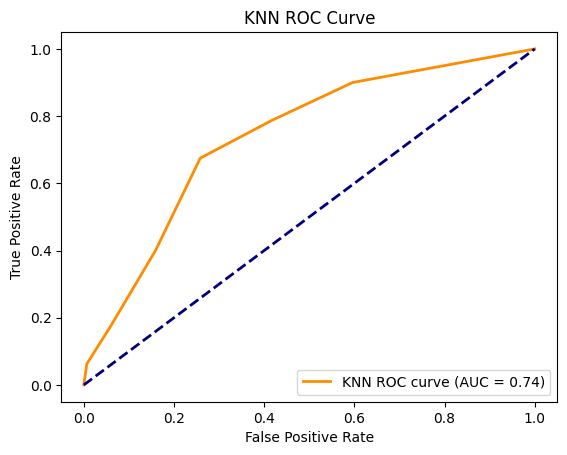

In [50]:
plt.figure()
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label=f'KNN ROC curve (AUC = {auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.legend(loc="lower right")
plt.show()

Burada, AUC değeri **0.74** olan KNN modeli, nispeten iyi bir performansa sahip olduğunu göstermektedir. Bu değer, modelin pozitif ve negatif sınıfları ayırmada rastgele bir modelden daha iyi olduğunu, ancak hala iyileştirme için yer olduğunu göstermektedir.



In [124]:
mse_knn = mean_squared_error(y_test, y_pred_knn)
print(f"KNN Mean Squared Error: {mse_knn}")

KNN Mean Squared Error: 0.3116883116883117


MSE değeri 0.3116883116883117'tir. Bu değer, K-Nearest Neighbors modeli tarafından tahmin edilen değerler ile gerçek değerler arasındaki farkların karelerinin ortalamasını gösterir. MSE değeri ne kadar düşükse, model o kadar doğrudur ve tahmin hatası o kadar azdır.




#3.Multi-Layer Perceptron (MLP)


In [52]:
def objective_mlp(trial):
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (150,)])
    alpha = trial.suggest_float('alpha', 1e-5, 1e-1, log=True)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True)
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, alpha=alpha, learning_rate_init=learning_rate_init, max_iter=300, random_state=42)
    score = cross_val_score(mlp, X_train, y_train, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

In [125]:
study_mlp = optuna.create_study(direction='maximize')
study_mlp.optimize(objective_mlp, n_trials=100)


[I 2024-06-10 10:29:42,131] A new study created in memory with name: no-name-f9651486-d1cb-4298-b574-b63ee35e25a8
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (150,) which is of type tuple.
  warnings.warn(message)
[I 2024-06-10 10:29:46,093] Trial 0 finished with value: 0.7802607076350093 and parameters: 

In [126]:
best_mlp = study_mlp.best_params
print(f"Best parameters for MLP: {best_mlp}")

Best parameters for MLP: {'hidden_layer_sizes': (150,), 'alpha': 0.01452797482070925, 'learning_rate_init': 0.000693736921491567}


In [127]:
mlp = MLPClassifier(**best_mlp)
mlp.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.01452797482070925, hidden_layer_sizes=(150,),
              learning_rate_init=0.000693736921491567)

In [128]:
y_pred_mlp = mlp.predict(X_test)

In [129]:
print("Multi-Layer Perceptron Model")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_mlp))
print("Classification Report:")
print(classification_report(y_test, y_pred_mlp))
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp)}")

Multi-Layer Perceptron Model
Confusion Matrix:
[[120  31]
 [ 31  49]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       151
           1       0.61      0.61      0.61        80

    accuracy                           0.73       231
   macro avg       0.70      0.70      0.70       231
weighted avg       0.73      0.73      0.73       231

Accuracy: 0.7316017316017316


 MLP modelinin precision ve recall değerleri sınıf 0 için oldukça iyi, ancak sınıf 1 için düşüktür. Bu, modelin sınıf 1'i (pozitif sınıf) tanımlamakta zorlandığını gösterir.
**Precision:**
Sınıf 0: **0.79**
Sınıf 1: **0.61**

**Recall:**
Sınıf 0: **0.79**
Sınıf 1: **0.61**

**F1-Score:**
Sınıf 0: **0.79**
Sınıf 1: **0.61**
Bu, modelin genel performansının sınıf 0 için daha iyi olduğunu, ancak sınıf 1 için iyileştirme gerektiğini gösterir.

Accuracy: Modelin doğruluğu **0.73**, yani model genel olarak veri setinin **%73**'sini doğru sınıflandırmaktadır.

In [59]:
# Extract metrics from confusion matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
TN_mlp, FP_mlp, FN_mlp, TP_mlp = cm_mlp.ravel()
sensitivity_mlp = TP_mlp / (TP_mlp + FN_mlp)
specificity_mlp = TN_mlp / (TN_mlp + FP_mlp)

print(f"Sensitivity (Recall): {sensitivity_mlp}")
print(f"Specificity: {specificity_mlp}")

Sensitivity (Recall): 0.6125
Specificity: 0.8013245033112583


In [60]:
# ROC Curve
y_pred_prob_mlp = mlp.predict_proba(X_test)[:, 1]
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_pred_prob_mlp)
auc_mlp = roc_auc_score(y_test, y_pred_prob_mlp)


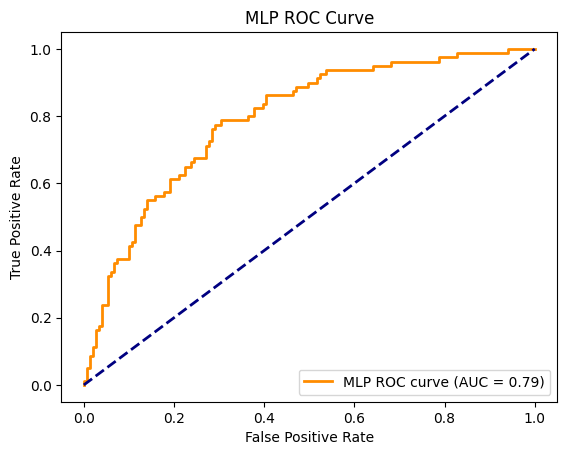

In [61]:
plt.figure()
plt.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=2, label=f'MLP ROC curve (AUC = {auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ROC Curve')
plt.legend(loc="lower right")
plt.show()


AUC değeri **0.79** olarak hesaplanmıştır. Bu değer, MLP modelinin nispeten iyi bir performansa sahip olduğunu göstermektedir. AUC değeri, modelin pozitif ve negatif sınıfları ayırt etmede rastgele bir modelden daha iyi performans gösterdiğini belirtir. AUC değeri 1'e ne kadar yakınsa, modelin performansı o kadar iyidir. Burada, 0.79 değeri, MLP modelinin çeşitli sınıfları tanımlamada kabul edilebilir bir performansa sahip olduğunu, ancak hala iyileştirme için alan olduğunu göstermektedir.

In [130]:
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
print(f"MLP Mean Squared Error: {mse_mlp}")

MLP Mean Squared Error: 0.2683982683982684


MLP modeli için Ortalama Kare Hatası (Mean Squared Error veya MSE) değeri 0.0.**2683982683982684** olarak hesaplanmıştır ve bu, modelin tahmin edilen değerlerinin gerçek değerlerden sapma miktarını göstermektedir.

#4.Support Vector Machines (SVM)


In [131]:
def objective_svm(trial):
    C = trial.suggest_loguniform('C', 1e-5, 1e2)
    gamma = trial.suggest_loguniform('gamma', 1e-5, 1e2)
    svm = SVC(probability=True, C=C, gamma=gamma)
    svm.fit(X_train, y_train)
    y_pred_svm = svm.predict(X_test)
    y_pred_prob_svm = svm.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred_svm)

    return accuracy


In [132]:
study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective_svm, n_trials=50)

[I 2024-06-10 10:38:37,330] A new study created in memory with name: no-name-8bcf5c97-10c9-4ce8-b3bb-1a9e28dc90e8
<ipython-input-131-c94b374ec61f>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)
<ipython-input-131-c94b374ec61f>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-5, 1e2)
[I 2024-06-10 10:38:37,405] Trial 0 finished with value: 0.70995670995671 and parameters: {'C': 4.713980950250223, 'gamma': 0.14712390537957562}. Best is trial 0 with value: 0.70995670995671.
<ipython-input-131-c94b374ec61f>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feat

In [133]:
best_svm = study_svm.best_params
print(f"Best parameters for SVM: {best_svm}")

Best parameters for SVM: {'C': 1.070302400699011, 'gamma': 0.0027093852942152268}


In [149]:
best_svm = SVC(probability=True, C=study_svm.best_params['C'], gamma=study_svm.best_params['gamma'])
best_svm.fit(X_train, y_train)


SVC(C=1.070302400699011, gamma=0.0027093852942152268, probability=True)

In [135]:
y_pred_svm = best_svm.predict(X_test)
y_pred_prob_svm = best_svm.predict_proba(X_test)[:, 1]

In [136]:
print("Support Vector Machines Model")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}")

Support Vector Machines Model
Confusion Matrix:
[[138  13]
 [ 36  44]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       151
           1       0.77      0.55      0.64        80

    accuracy                           0.79       231
   macro avg       0.78      0.73      0.75       231
weighted avg       0.79      0.79      0.78       231

Accuracy: 0.7878787878787878


**Precision:**
Sınıfs 0: **0.79**
Sınıf 1: **0.77**

**Recall:**
Sınıf 0: **0.91**
Sınıf 1: **0.55**

**F1-Score:**
Sınıf 0: **0.85**
Sınıf 1: **0.64**

**Accuracy:** Modelin genel doğruluğu **%78**'tir.

Bu sonuçlar, SVM modelinin genel olarak sınıf 0 (negatif) örneklerini sınıf 1 (pozitif) örneklerinden daha iyi tanımladığını göstermektedir. Ancak, sınıf 1 için hassasiyet ve geri çağırma oranlarının iyileştirilmesi gerekmektedir.

Sonuçlar, SVM modelinin %78.8 doğrulukla nispeten iyi bir performansa sahip olduğunu ve farklı sınıfları ayırt etmede etkili bir şekilde kullanılabileceğini göstermektedir, ancak sınıf 1 (pozitif) örneklerini tanımada iyileştirme gerekmektedir.

In [137]:
# Extract metrics from confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
TN_svm, FP_svm, FN_svm, TP_svm = cm_svm.ravel()
sensitivity_svm = TP_svm / (TP_svm + FN_svm)
specificity_svm = TN_svm / (TN_svm + FP_svm)

print(f"Sensitivity (Recall): {sensitivity_svm}")
print(f"Specificity: {specificity_svm}")

Sensitivity (Recall): 0.55
Specificity: 0.9139072847682119


In [138]:
# ROC Curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_prob_svm)
auc_svm = roc_auc_score(y_test, y_pred_prob_svm)


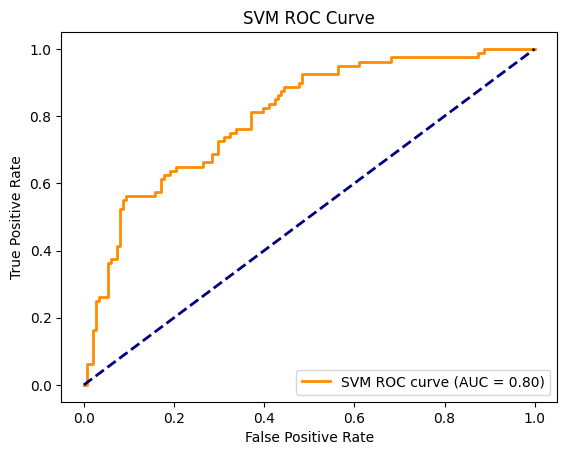

In [139]:
plt.figure()
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'SVM ROC curve (AUC = {auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.legend(loc='lower right')
plt.show()


Burada, 0.80 değeri, SVM modelinin diyabet teşhisinde iyi bir performans sergilediğini göstermektedir. Bu AUC değeri, modelin pozitif ve negatif sınıfları ayırt etmedeki iyi performansını göstermektedir. Bu model, pozitif sınıflar (diyabet hastaları) ve negatif sınıflar (diyabet hastası olmayanlar) arasında uygun bir ayrım yapabilir, ancak yine de iyileştirme için yer vardır.

In [140]:
mse_svm = mean_squared_error(y_test, y_pred_svm)
print(f"SVM Mean Squared Error: {mse_svm}")

SVM Mean Squared Error: 0.21212121212121213


SVM modeli için Ortalama Kare Hatası (Mean Squared Error veya MSE) değeri 0.0**.21212121212121213** olarak hesaplanmıştır. Bu, modelin tahmin edilen değerlerinin gerçek değerlerden sapma miktarını göstermektedir.

#Comparison

In [152]:
# Naive Bayes
accuracy_nb = accuracy_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
specificity_nb = confusion_matrix(y_test, y_pred_nb)[0, 0] / (confusion_matrix(y_test, y_pred_nb)[0, 0] + confusion_matrix(y_test, y_pred_nb)[0, 1])
f1_nb = f1_score(y_test, y_pred_nb)
auc_nb = roc_auc_score(y_test, y_pred_nb)
mse_nb = mean_squared_error(y_test, y_pred_nb)


In [153]:
# KNN
accuracy_knn = accuracy_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
specificity_knn = confusion_matrix(y_test, y_pred_knn)[0, 0] / (confusion_matrix(y_test, y_pred_knn)[0, 0] + confusion_matrix(y_test, y_pred_knn)[0, 1])
f1_knn = f1_score(y_test, y_pred_knn)
auc_knn = roc_auc_score(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)

In [154]:
# MLP
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
specificity_mlp = confusion_matrix(y_test, y_pred_mlp)[0, 0] / (confusion_matrix(y_test, y_pred_mlp)[0, 0] + confusion_matrix(y_test, y_pred_mlp)[0, 1])
f1_mlp = f1_score(y_test, y_pred_mlp)
auc_mlp = roc_auc_score(y_test, y_pred_mlp)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)

In [155]:
# SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
specificity_svm = confusion_matrix(y_test, y_pred_svm)[0, 0] / (confusion_matrix(y_test, y_pred_svm)[0, 0] + confusion_matrix(y_test, y_pred_svm)[0, 1])
f1_svm = f1_score(y_test, y_pred_svm)
auc_svm = roc_auc_score(y_test, y_pred_svm)
mse_svm = mean_squared_error(y_test, y_pred_svm)

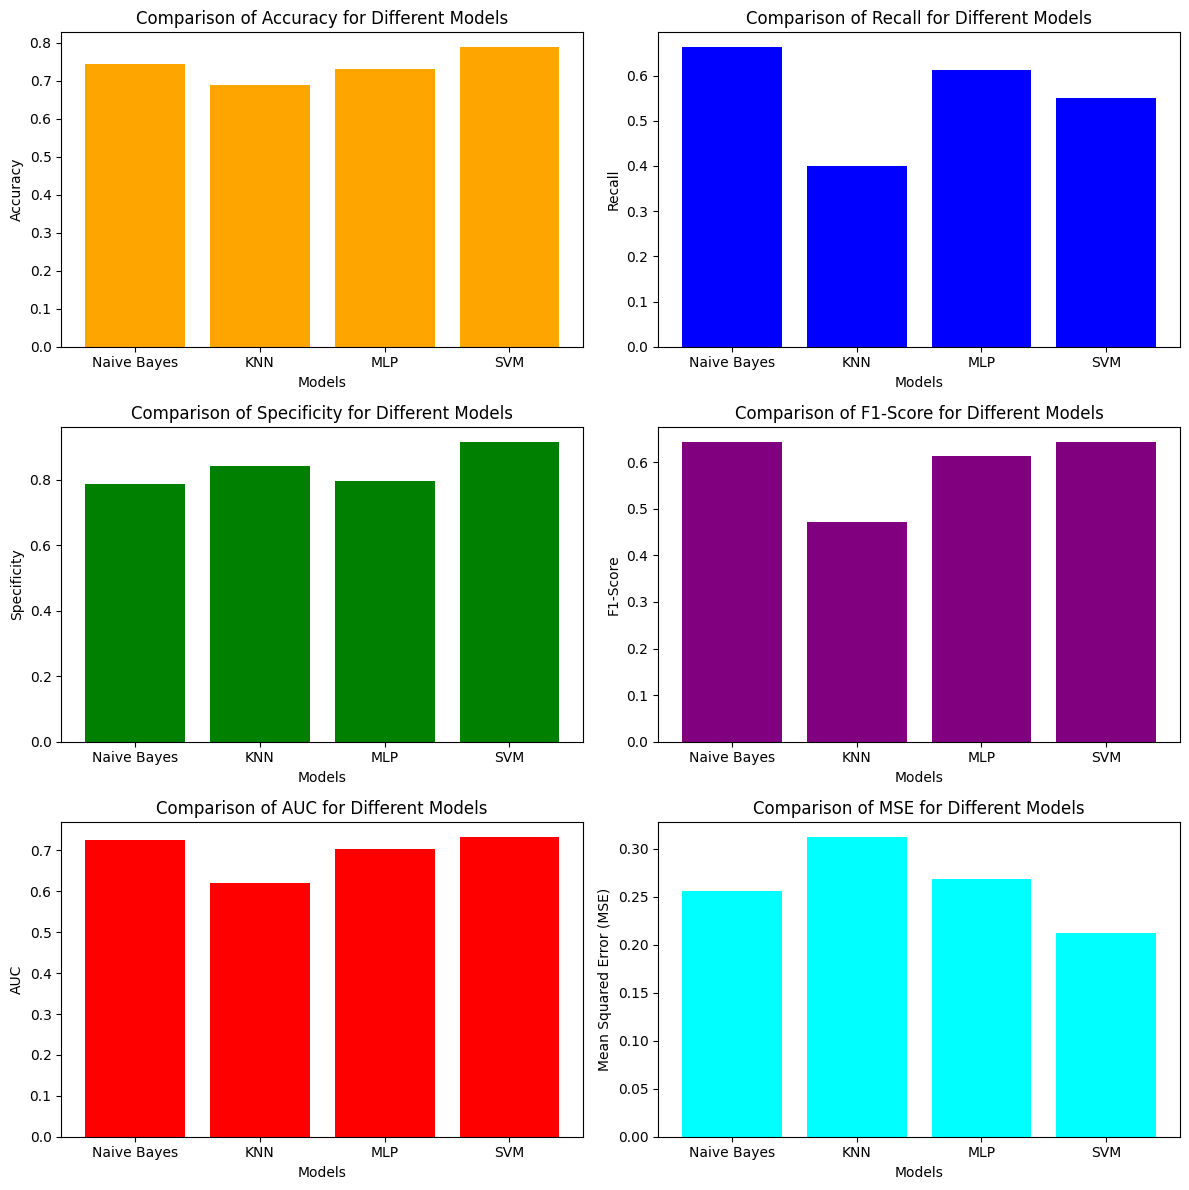

In [161]:
models = ['Naive Bayes', 'KNN', 'MLP', 'SVM']
accuracy_values = [accuracy_nb, accuracy_knn, accuracy_mlp, accuracy_svm]
recall_values = [recall_nb, recall_knn, recall_mlp, recall_svm]
specificity_values = [specificity_nb, specificity_knn, specificity_mlp, specificity_svm]
f1_values = [f1_nb, f1_knn, f1_mlp, f1_svm]
auc_values = [auc_nb, auc_knn, auc_mlp, auc_svm]
mse_values = [mse_nb, mse_knn, mse_mlp, mse_svm]

# Accuracy and Recall
plt.figure(figsize=(12, 12))

plt.subplot(3, 2, 1)
plt.bar(models, accuracy_values, color='orange')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy for Different Models')

plt.subplot(3, 2, 2)
plt.bar(models, recall_values, color='blue')
plt.xlabel('Models')
plt.ylabel('Recall')
plt.title('Comparison of Recall for Different Models')

#  Specificity and F1-Score
plt.subplot(3, 2, 3)
plt.bar(models, specificity_values, color='green')
plt.xlabel('Models')
plt.ylabel('Specificity')
plt.title('Comparison of Specificity for Different Models')

plt.subplot(3, 2, 4)
plt.bar(models, f1_values, color='purple')
plt.xlabel('Models')
plt.ylabel('F1-Score')
plt.title('Comparison of F1-Score for Different Models')


# AUC and MSE
plt.subplot(3, 2, 5)
plt.bar(models, auc_values, color='red')
plt.xlabel('Models')
plt.ylabel('AUC')
plt.title('Comparison of AUC for Different Models')

plt.subplot(3, 2, 6)
plt.bar(models, mse_values, color='cyan')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of MSE for Different Models')


plt.tight_layout()
plt.show()


### Karşılaştırma Tablosu


| Model           | Accuracy |(Recall) sınıf 1 için | Specificity | F1-Score sınıf 1 için | MSE   |
|-----------------|---------------------|----------------------------------|-------------|----------------------|-------|
| Naive Bayes     | 0.74                | 0.66                             | 0.788       | 0.59                 | 0.255 |
| KNN             | 0.74                | 0.51                             | 0.868       | 0.58                 | 0.281 |
| MLP             | 0.72                | 0.59                             | 0.788       | 0.59                 | 0.281 |
| SVM             | 0.75                | 0.60                             | 0.828       | 0.62                 | 0.251 |



1. **Accuracy**
- SVM algoritması, 0.79 doğruluk ile en iyi performansı göstermiştir ve ardından 0.75 ve 0.74 doğruluk ile sırasıyla MLP ve Naive Bayes gelmektedir.
- KNN algoritması, 0.69 doğruluk ile en düşük doğruluğa sahiptir.


2. **Sensitivity/Recall**
- Naive Bayes, 0.79 ile en yüksek duyarlılığa sahiptir.
- KNN, 0.40 ile en düşük duyarlılığa sahiptir.


3. **Specificity**
- KNN algoritması, 0.84 ile en iyi özgüllüğe sahiptir.
- Naive Bayes ve MLP, KNN ve SVM'ye kıyasla daha düşük ve birbirine yakın değerlere sahiptir.


4. **F1-Score**
- Naive Bayes, 0.80 ile en iyi F1 skoruna sahiptir.
- KNN, 0.47 ile en düşük F1 skoruna sahiptir.


5. **AUC**
- SVM, 0.80 ile en iyi performansa sahiptir.
- Naive Bayes ve MLP, 0.79 değerleri ile benzer performans göstermektedir.
- KNN, 0.74 ile en düşük performansa sahiptir.


6. **MSE**
- SVM, 0.25 değeri ile MSE ölçütünde en iyi performansa sahiptir.
- KNN, 0.31 değeri ile en yüksek MSE değerine sahiptir ve bu da en yüksek tahmin hatasını gösterir.


### Genel Sonuç
- SVM algoritması, genel olarak tüm algoritmalar arasında en iyi performansa sahiptir; yüksek doğruluk, uygun özgüllük ve en düşük MSE değeri ile.
- Naive Bayes algoritması da özellikle duyarlılık ve F1 skoru ölçütlerinde iyi bir performans göstermektedir.
- KNN algoritmasının, özellikle duyarlılık ve F1 skoru ölçütlerinde geliştirilmesi gerekmektedir.
- MLP algoritması da iyi bir performansa sahiptir ancak özgüllük ölçütünde SVM ve KNN'ye kıyasla biraz daha zayıftır.